## TODO:

#### Per image stats

- [ ] Objects per image - Average, Max, Min, and Frequency
- [ ] Object frequency per image region (hexagon plot or heatmap) 
- [ ] Pixel color statistics per image - Average, Max/Min, and Frequency r, g, b and 3 across all three channels
- [ ] Image similarity/dissimilarity
- [ ] Add test DataFrame for better juxtapostion 

#### Per class stats
- [ ] Class frequency distributions
- [ ] Class color distributions
- [ ] Class average per image

## Setup
1. Contains the packages/modules used for analysis
2. Identify the source directories and file extensions
3. Define utility functions

In [14]:
%matplotlib inline
from pandas.plotting import scatter_matrix, andrews_curves, radviz, parallel_coordinates
from matplotlib import pyplot as plt
from pandas import DataFrame
import numpy as np
import torch
import os
import glob
from PIL import Image

In [15]:
# point to locations of the images and labels
TRAIN_LABELS_DIR = 'E:\\steely\\tel_chipping\\custom_11_pre_qc_train_512_256_step\\train\\labels\\'
TRAIN_IMAGES_DIR = 'E:\\steely\\tel_chipping\\custom_11_pre_qc_train_512_256_step\\train\\images\\'

TEST_LABELS_DIR = 'E:\\steely\\tel_chipping\\custom_11_pre_qc_train_512_256_step\\val\\labels\\'
TEST_IMAGES_DIR = 'E:\\steely\\tel_chipping\\custom_11_pre_qc_train_512_256_step\\val\\images\\'

LABEL_EXT = ".txt"
IMG_EXT = ".png"

# sanity check
if os.path.isdir(TRAIN_LABELS_DIR):print("Training LABEL DIRECTORY exists!")
if os.path.isdir(TRAIN_IMAGES_DIR): print("Training IMAGE DIRECTORY exists!")
if os.path.isdir(TEST_LABELS_DIR):print("Testing LABEL DIRECTORY exists!")
if os.path.isdir(TEST_IMAGES_DIR): print("Testing IMAGE DIRECTORY exists!")

Training LABEL DIRECTORY exists!
Training IMAGE DIRECTORY exists!
Testing LABEL DIRECTORY exists!
Testing IMAGE DIRECTORY exists!


In [10]:
def is_grey_scale(img_path=None, img=None):
    if img_path and not img:
        img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return False
    return True

In [3]:
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

In [11]:
def object_rgb_stats(_coords_list, _tile_id):
    # UNTESTED and NOT IMPLEMENTED YET
    # load the image
    # TODO Check if the image or RGB 
    # TODO Decide how to handle the discrepancies with the number of values to report for gs and rgb
    _img_path = os.path.join(IMAGES_DIR, _tile_id + IMG_EXT)
    try:
        with Image.open(_img_path) as im:
            print(infile, im.format, f"{im.size}x{im.mode}")
    except OSError:
        pass
    if is_grey_scale(_img_path):
        im = im.convert("RGB")
        _mode = "GS"
    else:
        _mode = "RGB"
        
    # get the object boundary
    _obj_bbox = im.crop(tuple(_coords_list))
    _obj_bbox_np = np.asarray(_obj_bbox)
    _img_mean = np.mean(np.asarray(im), axis=(0,1))
    _img_var = np.var(np.asarray(im), axis=(0,1))
    _img_skew = np.skew(np.asarray(im), axis=(0,1))
    # get the bounding boxes rgb stats
    _ch_means = np.mean(_obj_bbox_np, axis=(0,1))
    _ch_vars = np.var(_obj_bbox_np, axis=(0,1))
    _stats = {
        "mode": _mode,
        "obj_means": _ch_means,
        "obj_variance": _ch_vars,
        "img_means": _img_mean,
        "img_var": _img_var,
        "img_skew": _img_skew, 
    }
    return _stats

## Load Labels into DataFrame
1. load the labels into a DataFrame
2. Optional for cleaning the DataFrame due to clipping boundaries and pre-qc

In [24]:
def load_label_data(_label_path, _label_ext,_verbosish=False):
    # Assumes the labels are already in YOLO format
    _master_list = []
    _tile_ids = []
    _label_files = glob.glob(_label_path + "/*" + _label_ext)
    _nf = 0

    for _lb_file in _label_files:
        # TODO: Refactor this mess.... probably condense into three or four lines with NumPy
        _label_list = []
        if os.path.isfile(_lb_file):
            _nf += 1  # label found
            _tile_id = os.path.split(_lb_file)[1].split('.')[0]
            with open(_lb_file, 'r') as _f:
                _l = np.array([_x.split() for _x in _f.read().strip().splitlines()], dtype=np.float64)  # labels
            if len(_l) > 0:
                for _row in _l:
                    _tile_ids.append(_tile_id)
                    _label_list.append(_row)
                _master_list.append(_label_list)

    _master_list = [_instance for _img in _master_list for _instance in _img]
    _column_headers = ['class', 'x_center_norm', 'y_center_norm','width_norm', 'height_norm']
    _labels_df = DataFrame(_master_list, index=None, columns=_column_headers)

    if len(_master_list) == len(_tile_ids):
        _labels_df["tile_id"] = _tile_ids
    _labels_df['class'] = _labels_df['class'].astype('category')
    
    if _verbosish: print(_labels_df.head())
    return _labels_df

In [36]:
_train_lbl_df = load_label_data(TRAIN_LABELS_DIR, LABEL_EXT)
_test_lbl_df = load_label_data(TEST_LABELS_DIR, LABEL_EXT)

_train_lbl_df["fold"] = "train"
_test_lbl_df["fold"] = "test"

_labels_df = _train_lbl_df.append(_test_lbl_df, ignore_index=True)
_labels_df["fold"] = _labels_df["fold"].astype("category")
_labels_df.head()

class  x_center_norm  y_center_norm  width_norm  height_norm  tile_id   fold
0   3.0       0.399097       0.377095    0.029187     0.031654  63_14_3  train
1   3.0       0.280510       0.369573    0.022610     0.033298  63_14_3  train
2   3.0       0.599385       0.072164    0.047730     0.049727  63_14_3  train
3   3.0       0.575870       0.060746    0.053921     0.056517  63_14_3  train
4   3.0       0.548216       0.053775    0.054720     0.055319  63_14_3  train

In [51]:
TRAIN2_LABELS_DIR = 'E:\\steely\\tel_chipping\\train_11_cat_pre_qc_dataset_512_510_step\\labels\\'
TRAIN2_IMAGES_DIR = 'E:\\steely\\tel_chipping\\train_11_cat_pre_qc_dataset_512_510_step\\images\\'

_train2_lbl_df = load_label_data(TRAIN2_LABELS_DIR, LABEL_EXT)

In [8]:
# Added due to pre-QC labelling and chipping errors
_labels_df.iloc[:,1:].clip(0, 1, inplace=True) # understand the implications that this is not reflected in the saved label and this may present atypical object view to model 
_labels_df.dropna(axis=0, inplace=True) 
_labels_df.head()

class  x_center_norm  y_center_norm  width_norm  height_norm  tile_id  \
12   0.0       0.061368       0.320848    0.039016     0.022872  0_21_14   
13   0.0       0.830623       0.895657    0.044398     0.021526  0_21_14   
14   5.0       0.729298       0.071109    0.107930     0.060692  0_18_15   
15   0.0       0.723764       0.041104    0.046042     0.027207  0_18_15   
16   0.0       0.811368       0.070848    0.039016     0.022872  0_18_15   

     x1_norm   y1_norm   x2_norm   y2_norm  obj_area_norm  obj_aspect_norm  
12  0.041860  0.309412  0.080876  0.332284       0.000892         1.705882  
13  0.808424  0.884894  0.852822  0.906420       0.000956         2.062500  
14  0.675333  0.040763  0.783263  0.101455       0.006550         1.778325  
15  0.700742  0.027501  0.746785  0.054708       0.001253         1.692308  
16  0.791860  0.059412  0.830876  0.082284       0.000892         1.705882

In [5]:
# Added aspect ratio, area, and the vertices of the bounding boxes to the DataFrame 
# TODO add non-normalized values
_labels_df[['x1_norm','y1_norm','x2_norm','y2_norm']] = xywh2xyxy(_labels_df.loc[:,'x_center_norm':'height_norm'].values)
_labels_df["obj_area_norm"] = _labels_df['width_norm'] * _labels_df['height_norm']
_labels_df["obj_aspect_norm"] = _labels_df['width_norm'] / _labels_df['height_norm']
_labels_df.head()
# TODO correlation between class and location in image?

class  x_center_norm  y_center_norm  width_norm  height_norm  tile_id  \
0   3.0       0.399097       0.377095    0.029187     0.031654  63_14_3   
1   3.0       0.280510       0.369573    0.022610     0.033298  63_14_3   
2   3.0       0.599385       0.072164    0.047730     0.049727  63_14_3   
3   3.0       0.575870       0.060746    0.053921     0.056517  63_14_3   
4   3.0       0.548216       0.053775    0.054720     0.055319  63_14_3   

    x1_norm   y1_norm   x2_norm   y2_norm  obj_area_norm  obj_aspect_norm  
0  0.384504  0.361268  0.413691  0.392922       0.000924         0.922078  
1  0.269205  0.352923  0.291815  0.386222       0.000753         0.679012  
2  0.575520  0.047301  0.623250  0.097027       0.002373         0.959839  
3  0.548909  0.032488  0.602830  0.089005       0.003047         0.954064  
4  0.520856  0.026115  0.575576  0.081434       0.003027         0.989170

## Basic Object Statistics
1. Describe
2. Class Counts

In [37]:
print(_labels_df.describe(include=[object, "category"]))
print(_labels_df.describe())

           class     tile_id    fold
count   161019.0      161019  161019
unique      11.0       11474       2
top          0.0  2505_62_23   train
freq     65849.0         474  155819
       x_center_norm  y_center_norm     width_norm    height_norm
count  161019.000000  161019.000000  161019.000000  161019.000000
mean        0.499619       0.493675       0.042983       0.030457
std         0.290285       0.289479       0.026158       0.016602
min         0.000000       0.000000       0.001046       0.000562
25%         0.247962       0.239718       0.027328       0.019235
50%         0.499709       0.496560       0.037970       0.029001
75%         0.751551       0.742283       0.049829       0.036886
max         1.000000       1.000000       0.413183       0.418565


In [27]:
print(_labels_df["class"].value_counts())
print("Total: {}".format(str(sum(_labels_df["class"].value_counts()))))

0.0     65849
3.0     31309
1.0     22821
4.0     18284
2.0     10814
7.0      5416
5.0      3320
9.0      1115
8.0       864
6.0       725
10.0      502
Name: class, dtype: int64
Total: 161019


In [53]:
print(_train2_lbl_df["class"].value_counts())
print("Total: {}".format(str(sum(_train2_lbl_df["class"].value_counts()))))

0.0     16451
1.0      5866
3.0      5208
4.0      4062
2.0      1608
7.0      1330
5.0       258
9.0       211
10.0      122
6.0        97
8.0        89
Name: class, dtype: int64
Total: 35302


In [54]:
print(_labels_df["class"].value_counts() - _train2_lbl_df["class"].value_counts())


0.0     49398
1.0     16955
2.0      9206
3.0     26101
4.0     14222
5.0      3062
6.0       628
7.0      4086
8.0       775
9.0       904
10.0      380
Name: class, dtype: int64


In [46]:
_class_splits = _labels_df.groupby("class")["fold"].value_counts().unstack()
print(_class_splits)

fold   test  train
class             
0.0     527  65322
1.0     139  22682
2.0     939   9875
3.0    2388  28921
4.0     482  17802
5.0     472   2848
6.0      55    670
7.0      51   5365
8.0     115    749
9.0      27   1088
10.0      5    497


## Visualizations

<AxesSubplot:xlabel='class'>

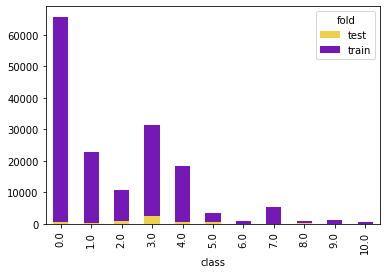

In [47]:
_class_splits.plot.bar(stacked=True,color={"train":"#7419b5","test":"#edd04e"})

array([[<AxesSubplot:title={'center':'x_center_norm'}>,
        <AxesSubplot:title={'center':'y_center_norm'}>],
       [<AxesSubplot:title={'center':'width_norm'}>,
        <AxesSubplot:title={'center':'height_norm'}>]], dtype=object)

<Figure size 432x288 with 0 Axes>

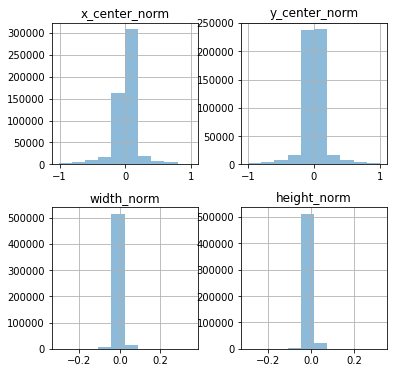

In [10]:
plt.figure()
_labels_df.iloc[:,1:5].diff().hist(alpha=0.5, figsize=(6, 6), )

array([[<AxesSubplot:title={'center':'x_center_norm'}>,
        <AxesSubplot:title={'center':'y_center_norm'}>],
       [<AxesSubplot:title={'center':'width_norm'}>,
        <AxesSubplot:title={'center':'height_norm'}>]], dtype=object)

<Figure size 432x288 with 0 Axes>

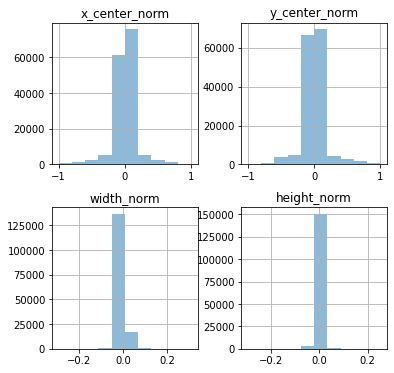

In [10]:
plt.figure()
_labels_df.iloc[:,1:5].diff().hist(alpha=0.5, figsize=(6, 6), )

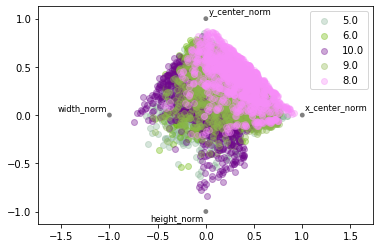

In [14]:
radviz(_labels_df[_labels_df['class'].isin([5,6,8,9,10])].iloc[:,:5], "class",alpha=0.35);

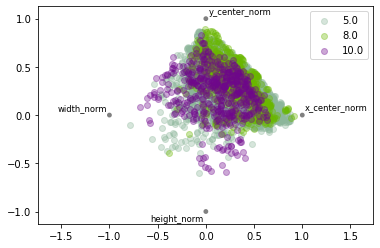

In [49]:
radviz(_labels_df[_labels_df['class'].isin([5,8,10])].iloc[:,:5], "class",alpha=0.35);

<AxesSubplot:>

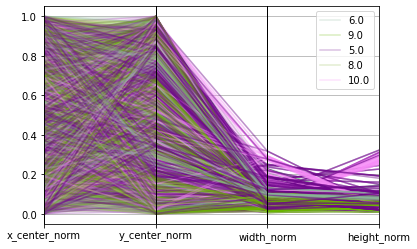

In [11]:
parallel_coordinates(_labels_df[_labels_df['class'].isin([5,6,8,9,10])].iloc[:,:5], "class",alpha=0.25)

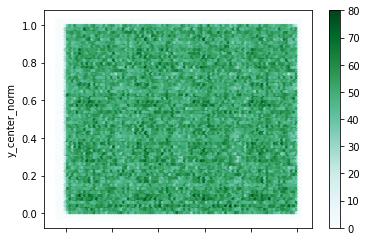

In [16]:
# Old density map for 11 class dataset chipped with 128 px step size
ax = _labels_df.plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

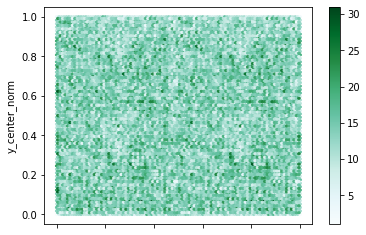

In [12]:
# object density plot for 256 step with custom train and validation split...
ax = _labels_df.plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

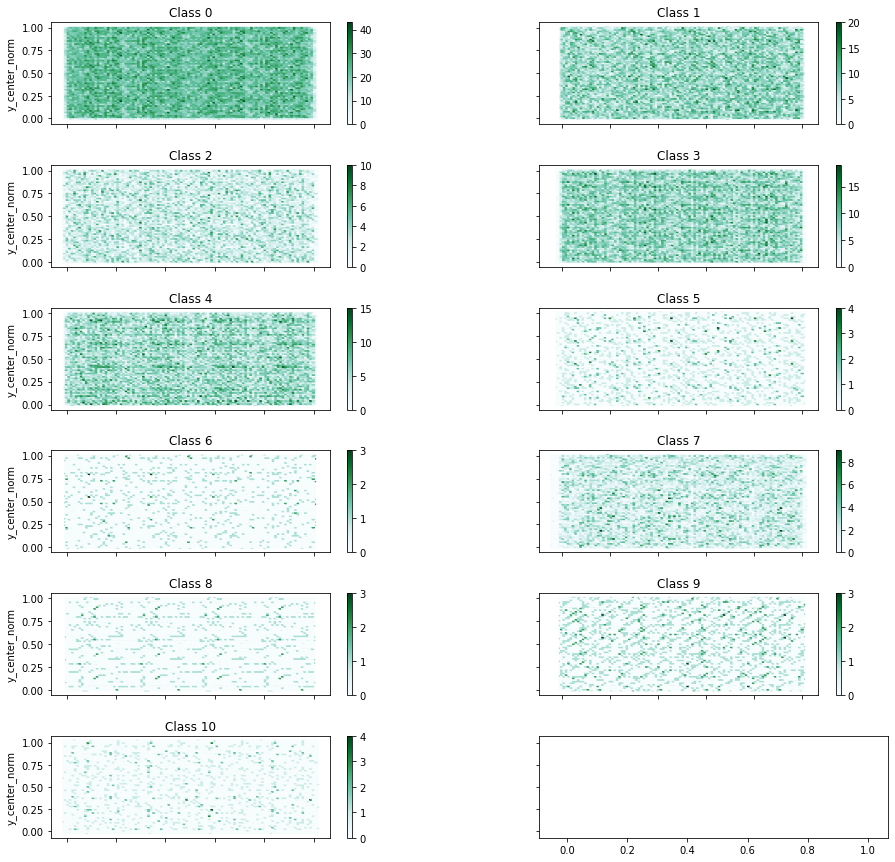

In [17]:
_classes = _labels_df["class"].unique()
_n_classes = len(_classes)
_cols = int(np.floor(_n_classes/2)) if int(np.floor(_n_classes/2)) < 3 else 2
_rows = int(np.ceil(_n_classes/_cols))
fig, axs = plt.subplots(_rows,_cols, figsize=(15, 15), facecolor='w', edgecolor='k', sharex='col', sharey='row')
fig.subplots_adjust(hspace =.4, wspace=.4)
_labels_df.iloc[:,1:5].clip(0,1,inplace=True)
axs = axs.ravel()
for _ax_id in range(len(axs)-1):
#     if _ax_id not in 
    _ax = _labels_df[_labels_df['class'] == _ax_id].plot(kind="hexbin", ax=axs[_ax_id], x="x_center_norm", y="y_center_norm", gridsize=100)
#     axs[_ax_id] = _ax
    axs[_ax_id].set_title("Class {}".format(str(_ax_id)))
#     axs[_ax_id].autoscale()

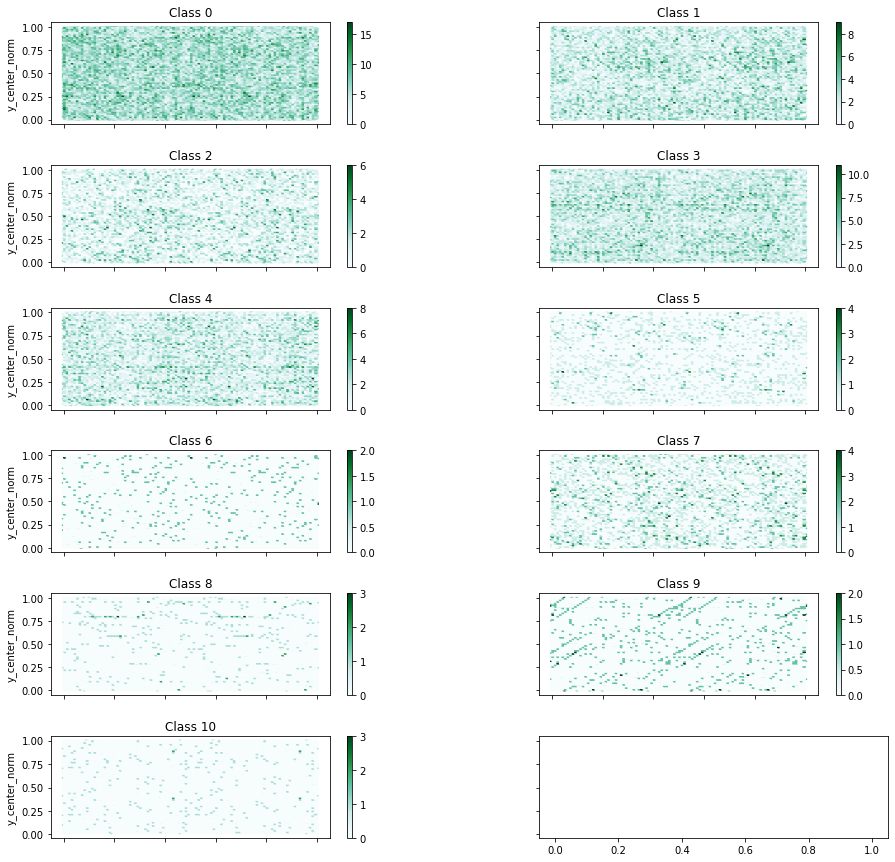

In [13]:
_classes = _labels_df["class"].unique()
_n_classes = len(_classes)
_cols = int(np.floor(_n_classes/2)) if int(np.floor(_n_classes/2)) < 3 else 2
_rows = int(np.ceil(_n_classes/_cols))
fig, axs = plt.subplots(_rows,_cols, figsize=(15, 15), facecolor='w', edgecolor='k', sharex='col', sharey='row')
fig.subplots_adjust(hspace =.4, wspace=.4)
_labels_df.iloc[:,1:5].clip(0,1,inplace=True)
axs = axs.ravel()
for _ax_id in range(len(axs)-1):
#     if _ax_id not in 
    _ax = _labels_df[_labels_df['class'] == _ax_id].plot(kind="hexbin", ax=axs[_ax_id], x="x_center_norm", y="y_center_norm", gridsize=100)
#     axs[_ax_id] = _ax
    axs[_ax_id].set_title("Class {}".format(str(_ax_id)))
#     axs[_ax_id].autoscale()

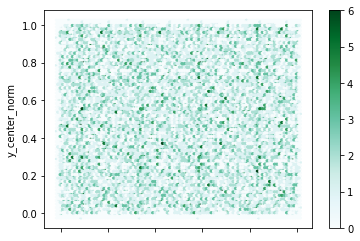

In [18]:
ax = _labels_df[_labels_df['class'].isin([5,6,8,9,10])].plot(kind='hexbin',x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

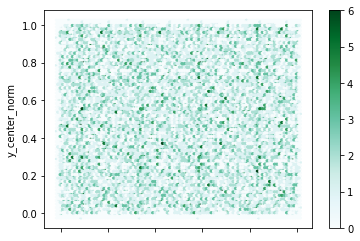

In [19]:
ax = _labels_df[_labels_df['class'].isin([5,6,8,9,10])].plot(kind='hexbin',x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

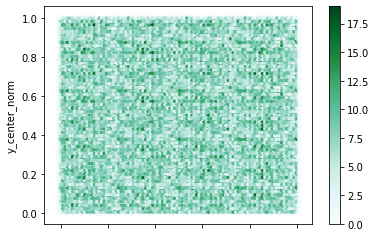

In [20]:
# class 3 256 step size
ax = _labels_df[_labels_df['class'] == 3].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

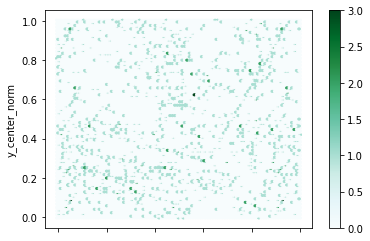

In [23]:
# 484 step size 
ax = _minorities_df[_minorities_df['class'] == 1].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

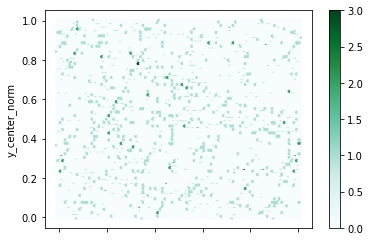

In [15]:
# 500 step size
ax = _minorities_df[_minorities_df['class'] == 1].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

array([[<AxesSubplot:title={'center':'x_center_norm'}>,
        <AxesSubplot:title={'center':'y_center_norm'}>],
       [<AxesSubplot:title={'center':'width_norm'}>,
        <AxesSubplot:title={'center':'height_norm'}>]], dtype=object)

<Figure size 432x288 with 0 Axes>

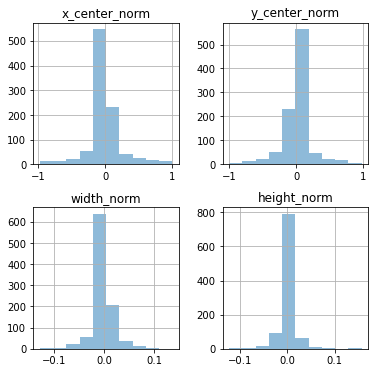

In [16]:
plt.figure()
_minorities_df[_minorities_df['class'] == 1].iloc[:,1:5].diff().hist(alpha=0.5, figsize=(6, 6), )

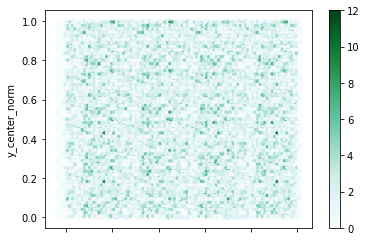

In [33]:
# 128 step size
ax = _minorities_df[_minorities_df['class'] == 2].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

In [13]:
_minorities_df = _labels_df[_labels_df["class"] != 0]
_minorities_df.head()

class  x_center_norm  y_center_norm  width_norm  height_norm  tile_id  \
14   5.0       0.729298       0.071109    0.107930     0.060692  0_18_15   
17   5.0       0.371950       0.453188    0.119889     0.056656  0_19_13   
18   5.0       0.479298       0.571109    0.107930     0.060692  0_19_13   
21   5.0       0.621950       0.203188    0.119889     0.056656  0_18_14   
22   5.0       0.729298       0.321109    0.107930     0.060692  0_18_14   

     x1_norm   y1_norm   x2_norm   y2_norm  obj_area_norm  obj_aspect_norm  
14  0.675333  0.040763  0.783263  0.101455       0.006550         1.778325  
17  0.312006  0.424860  0.431895  0.481515       0.006792         2.116095  
18  0.425333  0.540763  0.533263  0.601455       0.006550         1.778325  
21  0.562006  0.174860  0.681895  0.231515       0.006792         2.116095  
22  0.675333  0.290763  0.783263  0.351455       0.006550         1.778325

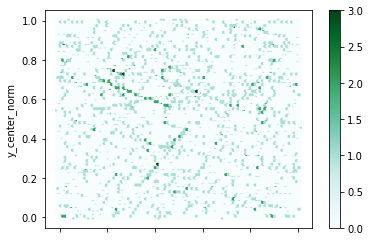

In [25]:
# 484 step size 
ax = _minorities_df[_minorities_df['class'] == 2].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

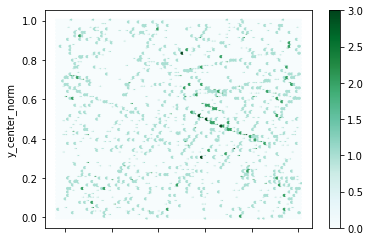

In [17]:
# 500 step size
ax = _minorities_df[_minorities_df['class'] == 2].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

array([[<AxesSubplot:title={'center':'x_center_norm'}>,
        <AxesSubplot:title={'center':'y_center_norm'}>],
       [<AxesSubplot:title={'center':'width_norm'}>,
        <AxesSubplot:title={'center':'height_norm'}>]], dtype=object)

<Figure size 432x288 with 0 Axes>

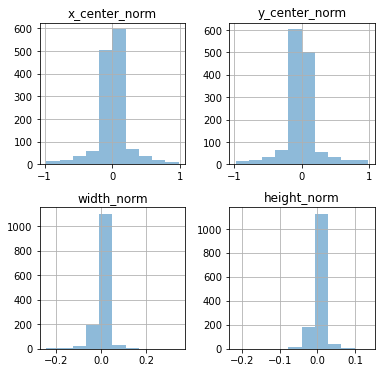

In [18]:
plt.figure()
_minorities_df[_minorities_df['class'] == 2].iloc[:,1:5].diff().hist(alpha=0.5, figsize=(6, 6), )

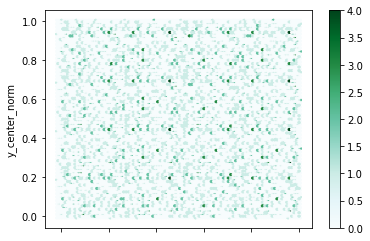

In [34]:
# 128 step size
ax = _minorities_df[_minorities_df['class'] == 3].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

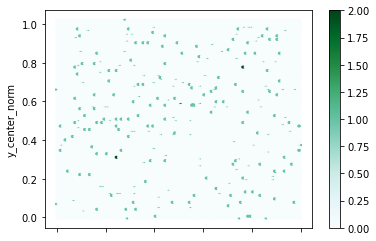

In [19]:
# 500 step size
ax = _minorities_df[_minorities_df['class'] == 3].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

array([[<AxesSubplot:title={'center':'x_center_norm'}>,
        <AxesSubplot:title={'center':'y_center_norm'}>],
       [<AxesSubplot:title={'center':'width_norm'}>,
        <AxesSubplot:title={'center':'height_norm'}>]], dtype=object)

<Figure size 432x288 with 0 Axes>

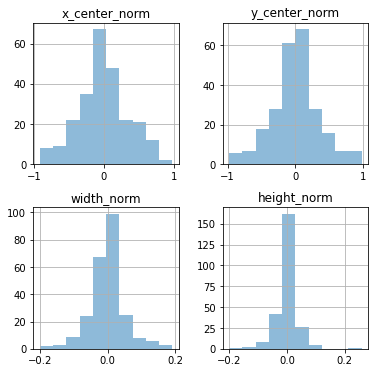

In [20]:
plt.figure()
_minorities_df[_minorities_df['class'] == 3].iloc[:,1:5].diff().hist(alpha=0.5, figsize=(6, 6), )

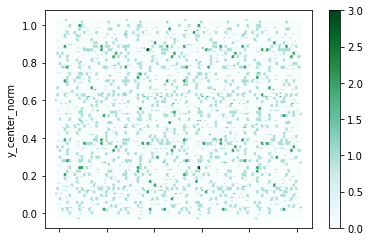

In [36]:
# 128 step size
ax = _minorities_df[_minorities_df['class'] == 4].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

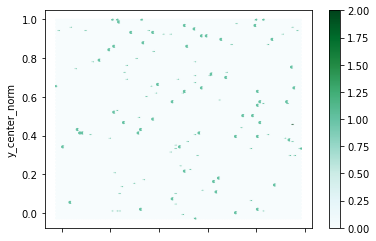

In [21]:
# 500 step size
ax = _minorities_df[_minorities_df['class'] == 4].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

array([[<AxesSubplot:title={'center':'x_center_norm'}>,
        <AxesSubplot:title={'center':'y_center_norm'}>],
       [<AxesSubplot:title={'center':'width_norm'}>,
        <AxesSubplot:title={'center':'height_norm'}>]], dtype=object)

<Figure size 432x288 with 0 Axes>

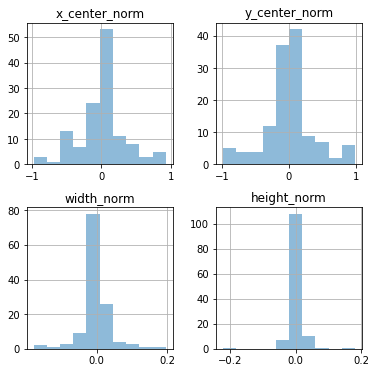

In [22]:
plt.figure()
_minorities_df[_minorities_df['class'] == 4].iloc[:,1:5].diff().hist(alpha=0.5, figsize=(6, 6), )

In [10]:
ax = _minorities_df.plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=100);
ax.autoscale()

NameError: name '_minorities_df' is not defined

# ================== Data iteration 1 (~6/17/2021) ===================

<ipython-input-197-eb9aa6b177ed>:2: FutureWarning: dtype lost in 'diff()'. In the future this will raise a TypeError. Convert to a suitable dtype prior to calling 'diff'.
  _labels_df.iloc[:,0:5].diff().hist(alpha=0.5, figsize=(6, 6), )


array([[<AxesSubplot:title={'center':'class'}>,
        <AxesSubplot:title={'center':'x_center_norm'}>],
       [<AxesSubplot:title={'center':'y_center_norm'}>,
        <AxesSubplot:title={'center':'width_norm'}>],
       [<AxesSubplot:title={'center':'height_norm'}>, <AxesSubplot:>]],
      dtype=object)

<Figure size 432x288 with 0 Axes>

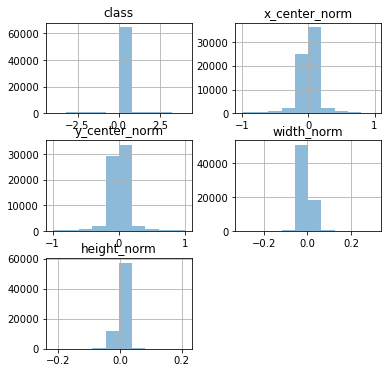

In [197]:
plt.figure()
_labels_df.iloc[:,0:5].diff().hist(alpha=0.5, figsize=(6, 6), )
# _labels_df.describe()
# _labels_df['class'].value_counts()

In [218]:
_labels_df["class"].value_counts()

0.0    60635
1.0     4342
3.0     3949
2.0      882
4.0      515
Name: class, dtype: int64

<AxesSubplot:>

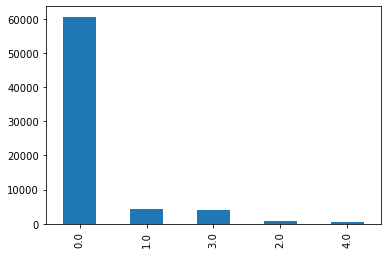

In [198]:
_labels_df["class"].value_counts().plot.bar()

In [200]:
_minorities_df = _labels_df[_labels_df["class"] != 0]
_minorities_df.head()

class  x_center_norm  y_center_norm  width_norm  height_norm    tile_id  \
32   3.0       0.532601       0.503660    0.120991     0.025693    47_15_9   
33   3.0       0.513849       0.536038    0.081985     0.025226    47_15_9   
71   2.0       0.988086       0.414459    0.083414     0.033186  296_21_48   
72   3.0       0.716021       0.828070    0.049929     0.034980  296_21_48   
73   3.0       0.672533       0.847329    0.051125     0.038867  296_21_48   

     x1_norm   y1_norm   x2_norm   y2_norm  obj_area_norm  obj_aspect_norm  
32  0.472106  0.490813  0.593097  0.516506       0.003109         4.709091  
33  0.472857  0.523425  0.554841  0.548651       0.002068         3.250000  
71  0.946379  0.397866  1.029793  0.431052       0.002768         2.513514  
72  0.691057  0.810580  0.740985  0.845560       0.001747         1.427350  
73  0.646971  0.827896  0.698096  0.866763       0.001987         1.315385

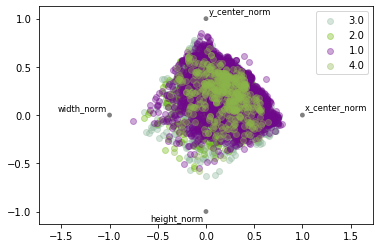

In [201]:
radviz(_minorities_df.iloc[:,:5], "class",alpha=0.35);

<AxesSubplot:>

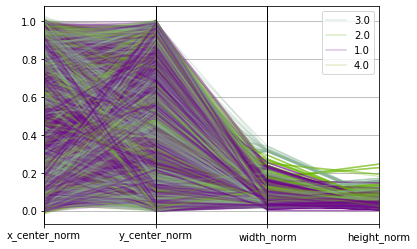

In [202]:
parallel_coordinates(_minorities_df.iloc[:,:5], "class",alpha=0.25)

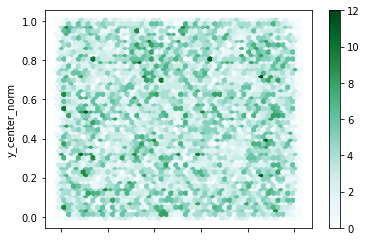

In [217]:
# _master_list
# _column_headers = ['class', 'x_center', 'y_center','width', 'height']
# _labels_df = DataFrame(_master_list, index=None, columns=_column_headers)
# ax = _minorities_df.plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=int(np.floor(len(_minorities_df)*0.1)));
ax = _minorities_df.plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=50);
ax.autoscale()

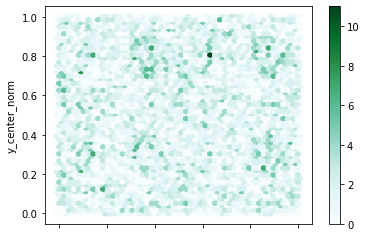

In [216]:
ax = _minorities_df[_minorities_df['class'] == 1].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=50);
ax.autoscale()

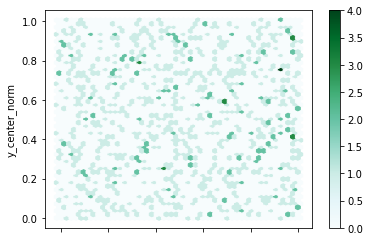

In [215]:
ax = _minorities_df[_minorities_df['class'] == 2].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=50);
ax.autoscale()

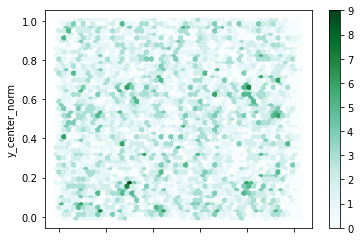

In [213]:
ax = _minorities_df[_minorities_df['class'] == 3].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=50);
ax.autoscale()

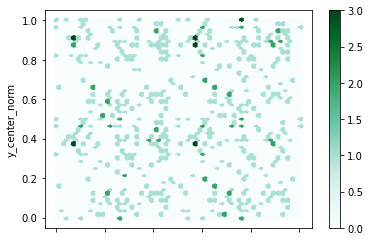

In [214]:
ax = _minorities_df[_minorities_df['class'] == 4].plot.hexbin(x="x_center_norm", y="y_center_norm", gridsize=50);
ax.autoscale()

In [ ]:
# load the labels into a pandas dataframe and create an area column, and aspect ratio of the objects, add object rgb means, 
# rgb var, normalized with respect to image means and var

# TODO: Add the image window information to the dataframe, i.e. load the image and get the RGB stats for the objects
def create_label_dataframe(_lbl_dir, _ext=".txt"):
    _master_list = []
    
    _label_files = glob.glob(_lbl_dir + "/*" + _ext)
    _nf = 0
    for _lb_file in _label_files:
        _label_list=[]
        if os.path.isfile(_lb_file):
            nf += 1  # label found
            with open(_lb_file, 'r') as _f:
                _l = np.array([_x.split() for _x in _f.read().strip().splitlines()], dtype=np.float64)  # labels
                if len(_l) > 0: 
                    _label_list.append([_row for _row in _l])
                    _master_list.append([_instance for _img in _label_list for _instance in _img])
    _master_list = [_instance for _img in _master_list for _instance in _img]
    _column_headers = ['class', 'x_center', 'y_center','width', 'height']
    _labels_df = DataFrame(_master_list, index=None, columns=_column_headers)
    _labels_df['class'] = _labels_df['class'].astype('category')
    _labels_df["obj_area"] = _labels_df['width']*_labels_df['height']
    _labels_df["obj_aspect"] = _labels_df['width']/_labels_df['height']
    print('Label Statistics: ')
    print(_labels_df.describe(include='all'))
    return _labels_df


In [ ]:
# graphs: frequencies, Box plots of classes' aspect ratio, hists plots of the channels of objects.
# scatter_matrix, parallel_coordinates, and andrew =_curves